In [6]:
import pandas as pd
import numpy as np 
from datetime import timedelta
import datetime as dt
from scipy import signal 
import holidays
from utils import *
from analysis import * 
import matplotlib.pyplot as plt 
import statsmodels.api as sm

In [7]:
data = pd.read_csv("../Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)
Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0
Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')

Electric = Electric[['Date', 'Load']]
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour

In [8]:
Electric

,Date,Load,Minutes,Hour
0,2008-01-01 00:15:00,15938.8,15,0
1,2008-01-01 00:30:00,15770.4,30,0
2,2008-01-01 00:45:00,15766.3,45,0
3,2008-01-01 01:00:00,15415.2,0,1
4,2008-01-01 01:15:00,15351.8,15,1
...,...,...,...,...
315643,2016-12-31 23:00:00,15952.7,0,23
315644,2016-12-31 23:15:00,15865.3,15,23
315645,2016-12-31 23:30:00,15693.5,30,23
315646,2016-12-31 23:45:00,15508.3,45,23


In [9]:
df = resampling_data(Electric)

df = df[~df.Load.isna()].reset_index(drop=True)
df

,Date,Hour,Minutes,Load,Day,Holiday,Day id
0,2008-01-01 01:00:00,1.0,22.5,60819.9,1,True,1
1,2008-01-01 02:00:00,2.0,22.5,57869.8,1,True,1
2,2008-01-01 03:00:00,3.0,22.5,55672.8,1,True,1
3,2008-01-01 04:00:00,4.0,22.5,55331.7,1,True,1
4,2008-01-01 05:00:00,5.0,22.5,54527.0,1,True,1
...,...,...,...,...,...,...,...
78907,2016-12-31 20:00:00,20.0,22.5,70390.3,5,False,366
78908,2016-12-31 21:00:00,21.0,22.5,66925.1,5,False,366
78909,2016-12-31 22:00:00,22.0,22.5,64900.1,5,False,366
78910,2016-12-31 23:00:00,23.0,22.5,63019.8,5,False,366


## Hourly Load Sum SARIMA Forecasting

In [ ]:
daily_Load = tmp.resample('d').mean()
daily_Load = daily_Load['Load']

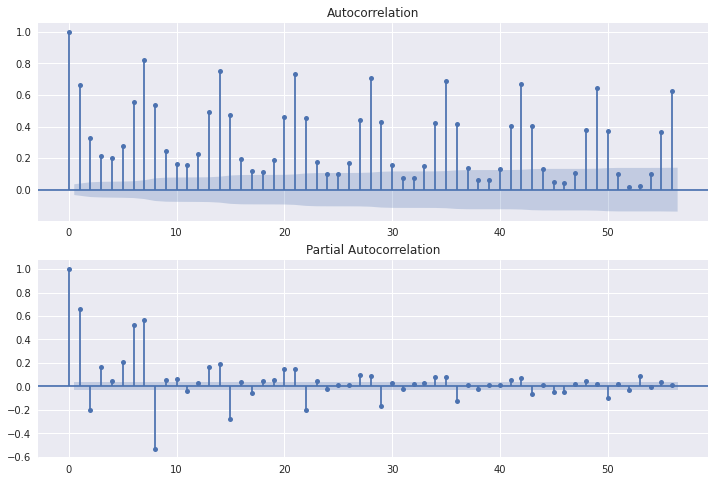

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
lag = 7*4*2
fig = sm.graphics.tsa.plot_acf(daily_Load, lags=lag, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(daily_Load, lags=lag, ax=ax2)

In [ ]:
adfuller(daily_Load, autolag=None, maxlag=1)

(-28.769167246810245,
 0.0,
 1,
 3287,
 {'1%': -3.43234099912876,
  '5%': -2.862419705448909,
  '10%': -2.5672382855426354})

In [ ]:
%%time 

# (4,0,5) x (1,1,0,7)
model = SARIMAX(daily_Load, order=(4,0,23), seasonal_order=(1,1,0,7))
results = model.fit()

/home/wronsmin/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


CPU times: user 6min 59s, sys: 15min 24s, total: 22min 24s
Wall time: 2min 4s


Text(0.5, 1.0, 'Poland Load')

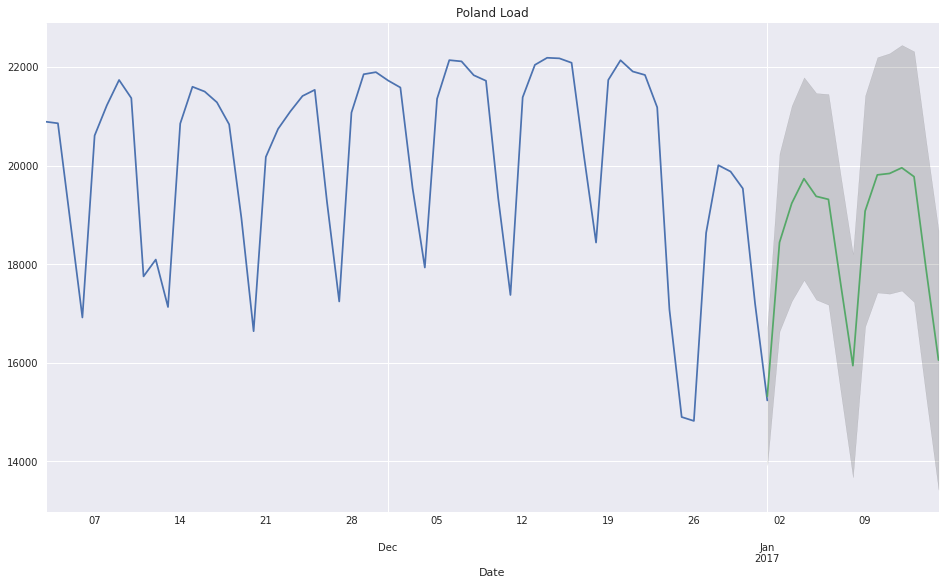

In [ ]:
forecast = results.get_prediction(start=daily_Load.index[-1], end=daily_Load.index[-1] + pd.DateOffset(days=14), dynamic= True)

daily_Load[-60:].plot()
forecast.predicted_mean.plot()
plt.fill_between(forecast.conf_int().index, forecast.conf_int()['lower Load'], forecast.conf_int()['upper Load'], color='k', alpha=0.15)
plt.title('Poland Load')